# Week 2: Distributions and variability 

The main goals for this week are to dig a little bit deeper into the idea of a feature's **distribution**, and understand ways of quantifying variability. For our purposes, we can think of a distribution as something like: "a systematic description of both the rage of values our data can take, and how frequently it takes on each value." Recognize that this is definitely an operational, 'intuitive' definition. There are a lot of nuances we're not going to worry about. 

```{admonition} Motivating questions for today
:class: seealso
- Given a dataset and/or a distribution, how do we think about its 'typical' and 'oddball' values? This will get us thinking about measures of central tendency, like the mean and median, and also quantiles. 
- What are some of the different types of distribution we tend to see, out there in the wild?
- How do we quantify and visualize the 'typical variation' of a data set? 

```

# Case Study: Neuronal morphology

We'll organize today's tour and analysis around the study of cellular morphology. Basically, this is a fancy way of saying we'll be thinking about cells' shapes, their geometry, and their branching patterns. The study of cellular morphology has a very illustrious history in neuroscience, and was integral to the development of the neuron doctrine: the idea that brain cells are individual units with freely ending fibers. It can seem hard to imagine ever having found this surprising, but this was fiercely contested by some of the finest minds in science in the nineteenth and even early twentieth centuries. The Spaniard Santiago Ramon y Cajal is usually considered the chief mason of the neuron doctrine. Working with what we'd now consider an extremely rudimentary microscope, and well before the advent of modern biological imaging, Cajal channeled his artistic energies and cataloged the myriad cellular forms he saw under the microscope in a series of thousands of drawings. These drawings are among the great monuments of scientific artwork and scientific discovery, and still find their way to art galleries around the world. 

Let's fastforward into the twentyfirst century, where we can easily access morphological data obtained from filling neurons with dyes and labels of different kinds. The block of code below imports some libraries we'll need, and also puts some some morphology data in our hands, courtesy of the Allen Institute. 

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from allensdk.core.cell_types_cache import CellTypesCache

ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
cell_specimen_id = 576107598
morphology = ctc.get_reconstruction(cell_specimen_id)

features = pd.DataFrame(ctc.get_all_features(require_reconstruction=True))
cell_metadata = pd.DataFrame(ctc.get_cells())

features_morpho = features.loc[:,'average_bifurcation_angle_local':]

df = pd.merge(features[['vrest', 'number_branches', 'threshold_v_ramp', 'total_volume']], 
              cell_metadata[['species', 'name', 'structure_hemisphere']], 
              left_index=True, right_index=True)

The object above called 'morphology' is a data file for a single cell. It contains information we can use to render the cell's shape, but it's not really in a format that's going to immediately make sense, visually. It's more like a long list of geometric properties (lengths and radii of short cylinders, and instructions for how to connect them). There's also metadata on the quality of reconstruction, etc. The block of code below does a little bit of work so we can see the cell. It's a lightly edited version of code you can find on one of the Allen's [sample notebooks] (https://allensdk.readthedocs.io/en/latest/_static/examples/nb/cell_types.html)

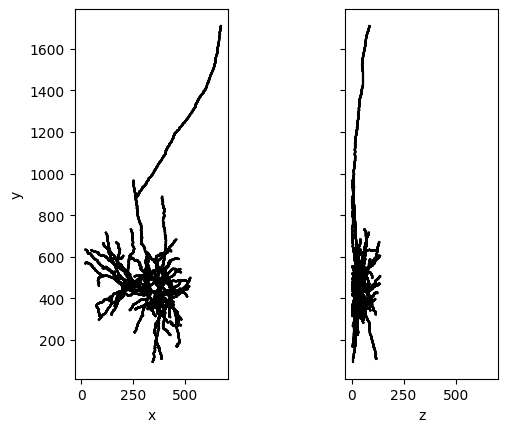

In [2]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box')
lens = [] # array of segment lengths

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')
        this_len = ((n['x'] - c['x']) ** 2) + ((n['y'] - c['y']) ** 2) + ((n['z'] - c['z']) ** 2)
        lens.append(this_len ** 0.5) # Euclidian distance btw. nodes
        
axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
plt.show()

# Basic intuitions about distributions

Quite pretty! At the risk of stating the obvious, you can see that there's a bit of variability in the branch lengths. Some are tiny, some are long, and one is super-long. Thinking about the branch lengths is actually a nice metaphor for the idea of a **distribution**. Recall from last time that the distribution of a variable (such as branch length) is a sort of bird's eye description of how frequently we expect to find it in different ranges. If we wanted to give a handwavy, highly non-quantititive description of the distribution of branch lengths for this one neuron, just from eyeballing it, it might be something like: mostly very short branches, a handful of intermediate length branches, and a very small number of very long ones. If we put on our statisticians' hat, we might hypothesize that branch lengths follow an **exponential distribution**. 

Text(0, 0.5, 'density')

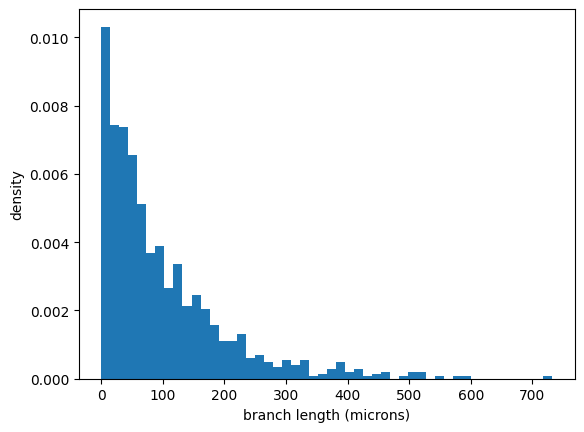

In [3]:
# sample from an exponential distribution to generate some synthetic data
exp = np.random.exponential(1,(1000,1)) * 100
plt.hist(exp,50,density=True);
plt.xlabel('branch length (microns)')
plt.ylabel('density')

Let's look at some examples of how variables are distributed in the morphology dataset. 

Soma size seems to maybe be something like a truncated gaussian (a gaussian where the left part of the distribution is clipped off at zero):

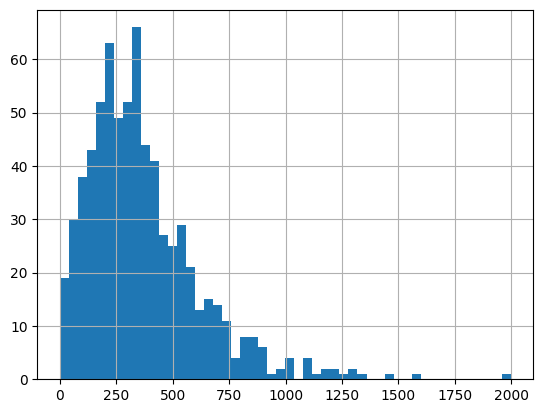

In [4]:
# Grab a range of columns corresponding to morphological data (we're throwing away ephys data for today)
morpho_features = features.loc[:,'average_bifurcation_angle_local':]

# Retain only numerical columns (i.e. toss categorical data)
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
morpho_features = morpho_features.select_dtypes(include=num_types)

# Plot a historgram of morphological features
morpho_features['soma_surface'].hist(bins=50);

Total cell volume looks like it might be exponential...

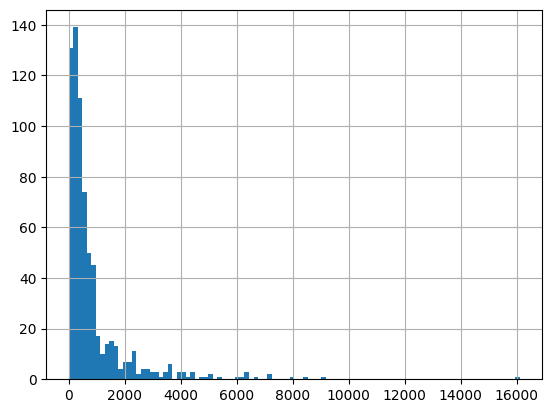

In [5]:
morpho_features['total_volume'].hist(bins=100);

But something interesting happens if we take the logarithm of our volume data and then plot the histogram

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


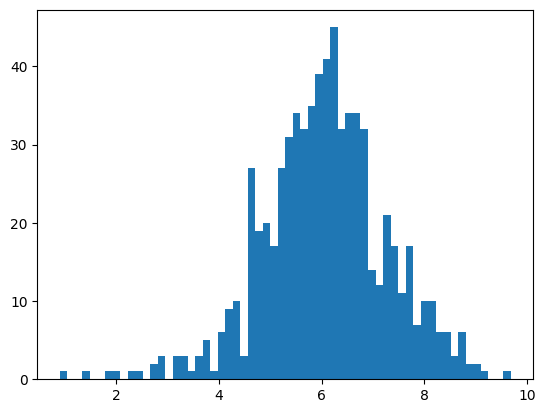

In [6]:
plt.hist(np.log(morpho_features['total_volume']).to_numpy(), bins=60);

Looks normal! In fact, we would call a distribution like this a **lognormal**. You tend to find it in growth phenomena, as well as a variety of seemingly unrelated places. The distribution of text lengths on internet comment sections, for example, seems to follow a lognormal. It's very common to perform mathematical **transformations** of your variables like this. Sometimes a distribution will look kind of funky at first, but will look like a much more familiar once we take the log of it, or square it, or take its inverse, etc. 

## Quantiles, percentiles, and standardized distributions. Asking "how surprised should I be" type questions

It's important to have a good understanding of the percentiles of a distribution. I find the intuition easiest to develop by thinking about a practical example rather than a formal definition. Imagine I line up 11 students, and order them by height, with the shortest student on the left, and the tallest on the right. If I asked you "what's the 50th percentile for height?" in this group of students, I'm asking you to tell me the height of the sixth person. I know that 50% of the students are that height *or shorter*. If you're going to a new school, and I tell you that you're in the 20th percentile for height, then you know you're on the short side at that school. 80% of the students will be taller than you. 

Just to make this clear: 

In [7]:
# Some fake height data
data = np.array([60, 62, 64, 68, 68, 69, 70, 72, 72, 74, 75])
heights = pd.DataFrame(data=data)

# We know the middle value is the 50th percentile, last value is the 100th percentile, etc. 
# But let's just check that the pandas 'quantile' function behaves the way we expect:
heights.quantile(0.9)

0    74.0
Name: 0.9, dtype: float64

In real life use-cases, we often just call upon Pandas' describe() function to give us some of the standard quantiles of our data set. For example, on the morphology data: 

In [8]:
features_morpho.describe()

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id_y,max_branch_order,max_euclidean_distance,...,overall_depth,overall_height,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,total_length,total_surface,total_volume
count,701.000000,0.0,701.000000,701.000000,701.000000,701.000000,0.0,7.010000e+02,701.000000,701.000000,...,701.000000,701.000000,701.000000,7.010000e+02,7.010000e+02,7.010000e+02,7.010000e+02,701.000000,701.000000,701.000000
mean,74.460981,NaN,0.878751,0.429317,57.034323,0.925859,NaN,5.859577e+08,7.723252,399.774930,...,93.769329,516.545095,325.709312,1.144000e-01,1.144000e-01,2.800000e-01,3.677248e+02,3832.188239,5699.400884,860.789884
std,8.246954,NaN,0.037041,0.160866,24.358354,0.076322,NaN,8.154347e+07,4.207190,227.038369,...,35.948250,281.136395,132.166569,1.972053e-15,1.972053e-15,9.999142e-16,2.534457e+02,2788.219926,5992.137552,1327.563202
min,49.483210,NaN,0.656121,0.000007,15.897436,0.622167,NaN,3.979053e+08,1.000000,63.020752,...,21.840000,54.607838,49.173247,1.144000e-01,1.144000e-01,2.800000e-01,7.668893e-08,251.987893,0.021819,-0.000076
25%,68.869230,NaN,0.861384,0.323491,41.479167,0.866617,NaN,4.961640e+08,5.000000,231.429096,...,66.777700,318.348333,231.013889,1.144000e-01,1.144000e-01,2.800000e-01,1.947356e+02,2224.234529,2373.483208,214.074139
50%,74.524769,NaN,0.884663,0.427836,50.818182,0.946812,NaN,5.874055e+08,6.000000,357.341058,...,89.302100,470.916212,292.386327,1.144000e-01,1.144000e-01,2.800000e-01,3.207796e+02,2949.286234,3748.792341,429.377765
75%,80.048330,NaN,0.904748,0.525646,67.100000,0.994360,NaN,6.528365e+08,10.000000,488.584760,...,119.145600,646.759680,398.576603,1.144000e-01,1.144000e-01,2.800000e-01,4.800480e+02,4248.902167,6182.628143,878.339557
max,115.432036,NaN,0.948915,1.156730,253.700000,1.122363,NaN,8.460831e+08,28.000000,1623.575309,...,183.960000,1988.717896,1295.286608,1.144000e-01,1.144000e-01,2.800000e-01,1.997534e+03,21775.359101,59086.631128,16108.163739


A plot type that's worth getting familar with is the box plot, which is like a souped-up bar graph. Whereas a typical bar graph will just give you information about the mean and standard error of a distribution, a box plot shows you the mean, as well as the 25th and 75th percentiles, which gives a better sense of the spread in our data: 

<AxesSubplot:>

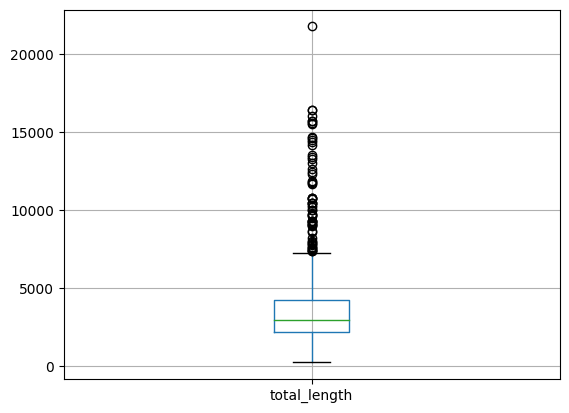

In [9]:
features_morpho.boxplot(column=['total_length'])

The 'whiskers' show the extreme ranges of our data (the min and max), and the top and bottom of the box are the third and first quartile of the data, respectively (i.e. 75th and 25th percentile). The individual markers are what pandas is considering outliers (things that are way outside the rest of the distribution, and which are possibly a bit suspect (measurement error, etc)). 


## Am I normal? Are my data normal? 

Sometimes you want to quickly size up your data and get a sense of whether it's normally distributed. This is a good thing to know, because if we're confident our data are normal, there are all kinds of nice theoretical guarantees we have that let us calculate confidence intervals, perform hypothesis tests, etc. 

A look at a distribution is sometimes all you need to rule out pathological cases of "definitely not not normal", but there can be a lot of subtlety here. A distribution may look bell-shaped, but actually have a lot more probability out on the tails than it 'should'. A quick way to get a sense of this is by plotting something called a Q-Q plot. 

We went over this in class, so I won't spend a ton of time on it, but basically you are plotting the percentiles (aka 'quantiles') of your 'test' distribution against a 'reference' (or 'theoretical') gaussian distribution. If two datasets have identical distributions, then their various percentiles (quantiles) should be similarly spaced apart. 

For a Gaussian, my 50th percentile will occur smack-dab in the center of my distribution, and my 25th and 75th percentiles will be relatively close to the 50th percentile since the middle is the densest and most probable part of the distribution. If I imagined pushing down on the top of my Gaussian, though, and squeezing some of its probability into the tails, the 25th and 75th percentiles will move further from the mean. 

A QQ plot is a graphical way of seeing whether your quantiles are spaced in the way you'd expect, under the assumptions of a certain distribution. Hopefully an example will help.

Recall that the logarithm of cell volume was normally distributed: 

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


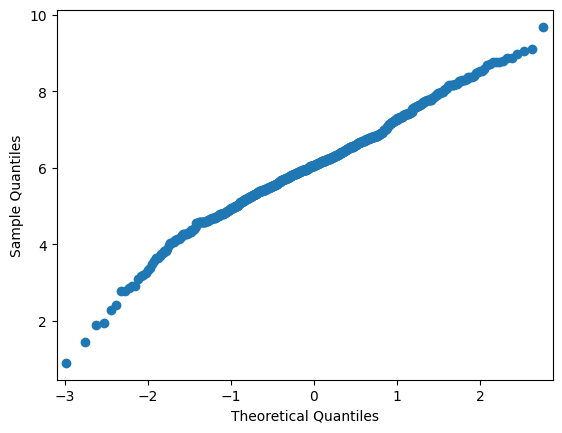

In [10]:
import numpy as np
import statsmodels.api as sm
import pylab as py

sm.qqplot(np.log(morpho_features['total_volume']))
py.show()

The QQ plot of theoretical vs. test (sample) quantiles falls (roughly) along a diagonal line. That's telling me that the two distributions bunch up in the same places, and flatten out in the same places. 

Let's make a QQ plot for the non-transformed data though: 

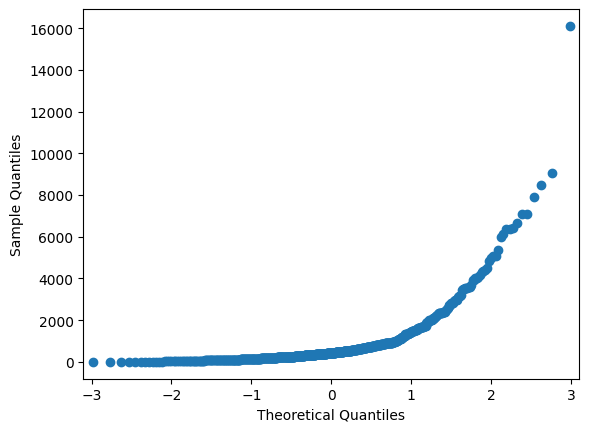

In [11]:
sm.qqplot(morpho_features['total_volume'])
py.show()

Different story! The QQ plot sags toward the right, away from the diagonal. That lets us know that there's a lot more probability out in right half of our theoretical distribution than our test distribution. 

## Sampling from distributions

It can be very useful to generate fake data from a known distribution -- a process known as **sampling**. If I asked you to give me 10 numbers sampled from a uniform distribution U(1,10), I'd expect you to give me a range of numbers between 1 and 10, with all numbers between the extremes being equally likely. Here's how you'd do that in python:

In [12]:
from scipy.stats import uniform
data_unif = uniform.rvs(1,10,size=10)
data_unif

array([ 7.03877578, 10.82338515,  1.83528547,  9.88268824,  2.9155369 ,
        1.03544016,  6.76632295,  8.92360462, 10.51312807,  5.29575437])

I'm not terribly surprised to see numbers close to 1 or 10, because all numbers in the range are equally likely. If I ask for 10 numbers sampled from a Normal distribution though, centered at 5 and with S.D.=2, I'd be very surprised to see numbers close to 10 (more than 2 SDs from the mean): 

In [13]:
from scipy.stats import norm
data_norm = norm.rvs(5,2, size=10)
data_norm

array([3.17320792, 3.88685301, 6.17360993, 4.53374441, 0.50559168,
       3.21359522, 4.01157788, 3.91530852, 5.19442715, 2.79791965])

Below, we'll walk through a few examples of working with distributions in python, just so you have some starter code to draw on.

### Example: Sampling from a uniform

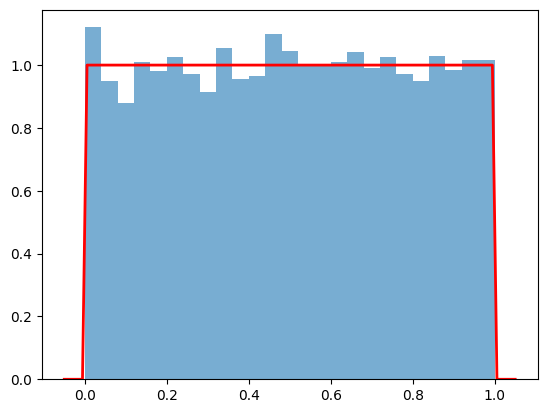

In [14]:
from scipy.stats import uniform
data_unif = uniform.rvs(size=5000)

plt.hist(data_unif, bins=25, density=True, alpha=0.6);
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = uniform.pdf(x)
plt.plot(x, p, 'r', linewidth=2)
mu, std = norm.fit(data_norm)
plt.show()

### Example: Sampling from a normal

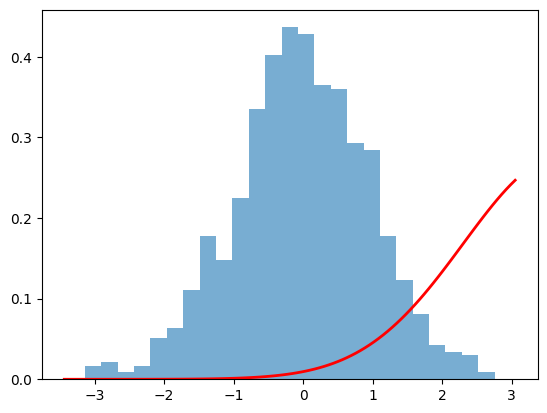

In [15]:
from scipy.stats import norm
data_norm = norm.rvs(0,1, size=1000)

plt.hist(data_norm, bins=25, density=True, alpha=0.6);
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
mu, std = norm.fit(data_norm)
plt.show()

# UPPING YOUR PANDAS GAME

Let's take a detour and dive a bit more into Pandas. It's worth gaining some familiarity with, and whether data analysis feels fun vs. frustrating (not that it can't be both!) will in large part boil down to how comfortable you are using this library. Pandas isn't hard the way quantum physics is hard; rather, it's hard the way that cooking is hard. There are a set of basic skills and 'idioms' that get used again and again, which, if you lack them, make the endeavor miserable and disaster-prone. But if you have these skills (and they are definitely super-learnable with patience and practice), they can open up an entire world for you. 

## Pandas Idiom 1: Getting subsets of your dataframe

We saw last time how to grab one or several columns of interest from a dataframe, by specifying them individually with a syntax like: 

In [16]:
features[['adaptation', 'total_volume']].head(5)

,adaptation,total_volume
0,NaN,2355.765059
1,NaN,2962.024123
2,0.044825,460.354199
3,0.002303,129.985840
4,0.093492,204.115177


Above, we've said: "throw away everything that isn't 'adaptation' or 'total_volume'". Sometimes, though, it's much easier to specify a range of columns without enumerating every single one. Say we were interested in grabbing all of the morphology features from the features dataframe. There are about 30 of them (and they're the last columns of the dataframe), and it would be a real pain to type each feature out and put it in brackets. Instead, we can use this trick: 

In [17]:
features.loc[:,'average_bifurcation_angle_local':].head(5)

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id_y,max_branch_order,max_euclidean_distance,...,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume
0,72.604110,NaN,0.850561,0.527213,75.133929,0.966709,NaN,668702901,11.0,496.779715,...,581.674568,0.1144,0.1144,0.28,444.247484,False,3D Neuron Reconstruction morphology,9995.218601,16666.213729,2355.765059
1,68.499396,NaN,0.934072,0.614133,61.172414,0.892380,NaN,680036168,13.0,474.631942,...,391.393464,0.1144,0.1144,0.28,1997.534304,False,3D Neuron Reconstruction morphology,6533.385774,13173.179026,2962.024123
2,77.679949,NaN,0.895664,0.488865,48.027778,0.928510,NaN,496001072,5.0,334.170810,...,236.976305,0.1144,0.1144,0.28,522.952356,False,3D Neuron Reconstruction morphology,2067.805445,3180.344934,460.354199
3,73.926537,NaN,0.896227,0.216384,62.282609,0.993927,NaN,596792650,4.0,226.722766,...,332.948545,0.1144,0.1144,0.28,76.604264,False,3D Neuron Reconstruction morphology,3488.103438,2371.871389,129.985840
4,89.985385,NaN,0.821116,0.289549,54.000000,1.000000,NaN,599474134,7.0,228.889283,...,374.603996,0.1144,0.1144,0.28,77.936062,False,3D Neuron Reconstruction morphology,2977.161146,2703.134880,204.115177


The .loc operator lets us do numpy style slicing, were we can specify sets of continuous rows and columns that we want to slice over. The basic syntax is: 

dataframe.loc[row expression, column expression]

The :, above, in the row expression says, as in numpy "get me all the rows". The 'average_bifurcation_angle_local': expression in the column expression says "get me columns starting from 'average_bifurcation angle', and extending to the end of the dataframe. 

If, instead, you wanted to grab all the rows, and columns ranging from 'average_bifurcation angle' to 'average_diameter', the relevant expression would be: 

In [18]:
features.loc[:,'average_bifurcation_angle_local':'average_diameter'].head(5)

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter
0,72.604110,NaN,0.850561,0.527213
1,68.499396,NaN,0.934072,0.614133
2,77.679949,NaN,0.895664,0.488865
3,73.926537,NaN,0.896227,0.216384
4,89.985385,NaN,0.821116,0.289549


Recall that .head(5) in the above examples is just telling pandas to show the first 5 rows. It dosn't have anything to do with the actual query we're performing.

## Pandas Idiom 2: Filtering your data on the basis of a conditional

In the .loc example above, we knew in advance what exact subset of our data we were looking for, and how to call it explicitly. A lot of the time, though, we don't know the exact rows or columns we'd like to grab, just that we're interested in a set of rows/columns that have something in common, or meet some criterion. For example, we might want rows that correspond only to mouse data, and not human data. Or we might want rows where the average diamater is greater than some certain value.

That latter query (selecting for diameters above a certain threshold) would look like this: 

In [19]:
features_morpho[features_morpho['average_diameter'] > 0.9]

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id_y,max_branch_order,max_euclidean_distance,...,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume
47,81.578194,NaN,0.802499,1.033745,67.100000,1.000000,NaN,680043920,12.0,475.663692,...,518.922373,0.1144,0.1144,0.28,918.551337,False,3D Neuron Reconstruction morphology,4006.243938,12930.564179,4322.984221
323,82.830914,NaN,0.792147,1.156730,68.000000,0.993137,NaN,673700971,8.0,356.752592,...,370.970282,0.1144,0.1144,0.28,253.123638,False,3D Neuron Reconstruction morphology,5784.522053,21069.567363,6677.460448
609,81.654732,NaN,0.715295,1.003061,145.794118,1.000000,NaN,603515592,6.0,516.702575,...,884.731477,0.1144,0.1144,0.28,527.632192,False,3D Neuron Reconstruction morphology,6075.055529,19151.512838,4986.316997


Let's unpack this, because it has a nested structure that can look a bit confusing at first. If we were to run the expression inside the outer bracket, we'd get the following: 

In [20]:
features_morpho['average_diameter'] > 0.9

0      False
1      False
2      False
3      False
4      False
       ...  
696    False
697    False
698    False
699    False
700    False
Name: average_diameter, Length: 701, dtype: bool

The expression is basically asking "is it the case that the average diameter is greater than 0.9?". It evaluates as false just about everywhere, and is true only for 3 rows where the condition is met. When we then feed this long list of 'True's and 'False's to the dataframe, it knows that you're asking for the data only where the condition evalues as 'True'. 